In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

# Class 12: Introduction to the `linearsolve` Module

In general, dynamic stochastic general equilibrium (DSGE) models do not admit analytic (i.e., pencil-and-paper) solutions and they are time-consuming to work with. The `linearsolve` module approximates, solves, and simulates DSGE models.

## Installing `linearsolve`

`linearsolve` is not included in the Anaconda Python installation and so before you can import it, you need to download and install the `linearsolve` package from PyPI, the Python Package Index. In Windows, open the Anaconda Prompt and in Mac, open the Terminal and run the following commmand:

    pip install linearsolve
    
You only have to install the package once.

In [209]:
# Import the linearsolve under the 'ls' namespace
import linearsolve as ls

## Example: A One-Equation Model of TFP

Consider the following AR(1) specification for $\log$ TFP:

\begin{align}
\log A_{t+1} & = \rho \log A_t + \epsilon_{t+1} \tag{1}
\end{align}

where $\epsilon_{t+1} \sim \mathcal{N}(0,\sigma^2)$. Let's simulate the model with `linearsolve`. To do this we need to do several things:

1. Create a Pandas series that stores the names of the parameters of the model.
2. Define a function that returns the equilibrium conditions of the model solved for zero.
3. Initialize an instance of the `linearsolve.model` class
4. Compute and input the steady state of the model.
5. Approximate and solve the model.
6. Compute simulations of the model.

**Step 1:** Create a variable called `parameters` that stores parameter values as a Pandas Series.

In [210]:
# Create a variable called 'parameters' that stores parameter values as a Pandas Series
parameters = pd.Series()
parameters['rho'] = .9
parameters['sigma_squared'] = 1

# Print stored parameter values
print(parameters)

rho              0.9
sigma_squared    1.0
dtype: float64


**Step 2:** Define a function called `equilibrium_equations` that evaluates the equilibrium 
equations of model solved for zero. The function should accept three arguments:

1. `variables_forward`: Values of $t+1$-dated variables
2. `variables_current`: Values of $t-1$-dated variables
3. `parameters`: Pandas Series with the parameters for the model

The function should return a NumPy array of the model's equilibrium conditions solved for zero.

In [222]:
# Define a function called 'equilibrium_equations' that evaluates the equilibrium equations of model. PROVIDED
def equilibrium_equations(variables_forward,variables_current,parameters):
    
    # Create a variable called 'p' that storres the model's parameters. PROVIDED.
    p = parameters
    
    # Create variable called 'cur' that stores the values of current (date t) variables. PROVIDED.
    cur = variables_current
    
    # Create variable called 'fwd' that stores the values of one-period-ahead (date t+1) variables. PROVIDED.
    fwd = variables_forward

    # Create variable called 'tfp_proc' that returns the law of motion for TFP solved for zero (exogenous shock excluded)
    tfp_proc = p.rho*np.log(cur.a) - np.log(fwd.a)
    
    # Return equilibrium conditions stacked in a numpy array. PROVIDED.
    return np.array([
        tfp_proc
        ])

**Step 3:** Initialize a model instance using the `ls.model()` function. The 

1. `equations`: Name of function that stores the equilibrium conditions
2. `nstates`: Number of *state* variables (i.e., variables that are *predetermined*)
3. `varNames`: List of the names of the endogenous variables
4. `shockNames`: List of the names of the exogenous shocks
5. `parameters`: Pandas Series of parameter values

In [214]:
# Initialize a model instance using the ls.model() function
model = ls.model(equations = equilibrium_equations,
                 nstates=1,
                 varNames=['a'],
                 shockNames=['eA'],
                 parameters = parameters)

**Step 4:** Set the steady state of the model. Either use the `.compute_ss()` method which requires an initial guess of what the steady state is. Or set the steady state `.ss` attribute directly.

In [226]:
# Use linearsolve to compute the steady state of the model using the .compute_ss() method of model
model.compute_ss([1])
print(model.ss)

a    1.0
dtype: float64


In [227]:
# Set the .ss attribute of model directly.
model.ss = pd.Series({'a':1})

**Step 5:** Compute a transform the model into a log-linear approximation around the nonstochastic steady state. Then rewrite the equilibrium conditions so that all endogenous variables are expressed as linear functions of state variables and exogenous shocks.

In [228]:
# Appproximate and solve using the .approximate_and_solve() method
model.approximate_and_solve()

**Step 6:** Simulate the model using one of the following methods:

1. `.impulse()`: Compute impulse responses to a one-time shock to each exogenous variables. Results stored in `.irs` attribute.
2. `.stoch_sim()`: Compute stochastic simulation. Results stored in `.simulated` attribute.

First, we'll compute an impulse response simulation. Let's consider the effect of a one time shock to $\epsilon$ of 0.01 in period 5. Simulate 41 periods.

In [263]:
# Compute impulse response of a to a one-time shock to eA
model.impulse(T=41,t0=5,shocks=[0.01])

# Print model.irs
print(model.irs)

{'eA':       eA             a         k         y
0   0.00  0.000000e+00  0.000000  0.000000
1   0.00  0.000000e+00  0.000000  0.000000
2   0.00  0.000000e+00  0.000000  0.000000
3   0.00  0.000000e+00  0.000000  0.000000
4   0.00  0.000000e+00  0.000000  0.000000
5   0.01  1.000000e-02  0.000000  0.010000
6   0.00  7.500000e-03  0.000250  0.007588
7   0.00  5.625000e-03  0.000433  0.005777
8   0.00  4.218750e-03  0.000567  0.004417
9   0.00  3.164063e-03  0.000663  0.003396
10  0.00  2.373047e-03  0.000732  0.002629
11  0.00  1.779785e-03  0.000779  0.002052
12  0.00  1.334839e-03  0.000811  0.001619
13  0.00  1.001129e-03  0.000831  0.001292
14  0.00  7.508469e-04  0.000843  0.001046
15  0.00  5.631351e-04  0.000848  0.000860
16  0.00  4.223514e-04  0.000848  0.000719
17  0.00  3.167635e-04  0.000845  0.000612
18  0.00  2.375726e-04  0.000839  0.000531
19  0.00  1.781795e-04  0.000831  0.000469
20  0.00  1.336346e-04  0.000822  0.000421
21  0.00  1.002260e-04  0.000812  0.000384
22  

In [264]:
# Print element in model.irs that corresponds to shock to TFP
print(model.irs['eA'].head(10))

     eA         a         k         y
0  0.00  0.000000  0.000000  0.000000
1  0.00  0.000000  0.000000  0.000000
2  0.00  0.000000  0.000000  0.000000
3  0.00  0.000000  0.000000  0.000000
4  0.00  0.000000  0.000000  0.000000
5  0.01  0.010000  0.000000  0.010000
6  0.00  0.007500  0.000250  0.007588
7  0.00  0.005625  0.000433  0.005777
8  0.00  0.004219  0.000567  0.004417
9  0.00  0.003164  0.000663  0.003396


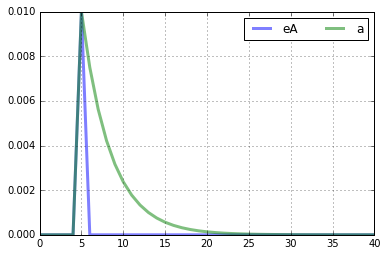

In [265]:
# Plot simulation
model.irs['eA'][['eA','a']].plot(lw='3',alpha=0.5,grid=True).legend(loc='upper right',ncol=2)

Next, we'll use the `.stoch_sim()` method to compute a stochastic simulation. The method takes arguments:

1. `seed`: Seed of NumPy RNG. (Optional)
2. `T`: Number of periods to simulate
3. `covMat`: Covariance matrix for exogenous shock process

The simulation should be for 201 periods.

In [266]:
# Compute stochastic simulation
model.stoch_sim(seed=126,T=201,covMat= [[parameters['sigma_squared']]])

# Print the first 10 rows of `model.simulated`
print(model.simulated.head(10))

         eA   eK         a         k         y
0 -0.003604  0.0 -0.002612 -0.001574 -0.003162
1  0.004610  0.0  0.002651 -0.001613  0.002087
2 -0.003900  0.0 -0.001912 -0.001521 -0.002444
3 -0.000264  0.0 -0.001698 -0.001544 -0.002239
4 -0.000491  0.0 -0.001765 -0.001561 -0.002312
5  0.001842  0.0  0.000518 -0.001580 -0.000035
6  0.003770  0.0  0.004159 -0.001541  0.003619
7  0.000871  0.0  0.003989 -0.001412  0.003495
8  0.001788  0.0  0.004780 -0.001290  0.004329
9 -0.005110  0.0 -0.001525 -0.001149 -0.001927


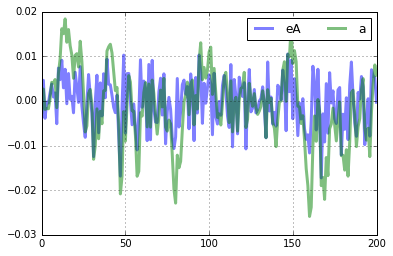

In [267]:
# Plot the stochastic simulation
model.simulated[['eA','a']].plot(lw='3',alpha=0.5,grid=True).legend(loc='upper right',ncol=2)

## Example 2: The STochastic Solow Growth Model Revisited

Now consider the following system of equations:

\begin{align}
Y_t & = A_t K_t^{\alpha} \tag{2}\\
K_{t+1} & = sY_t + (1-\delta) K_t \tag{3}\\
\log A_{t+1} & = \rho \log A_t + \epsilon_{t+1} \tag{4}
\end{align}

where $\epsilon_{t+1} \sim \mathcal{N}(0,\sigma^2)$. Let's simulate the model with `linearsolve`. Before proceding, let's also go ahead and rewrite the model with all variables moved to the lefthand side of the equations:

\begin{align}
0 & = A_t K_t^{\alpha} - Y_t \tag{5}\\
0 & = sY_t + (1-\delta) K_t - K_{t+1} \tag{6}\\
0 & = \rho \log A_t + \epsilon_{t+1} - \log A_{t+1} \tag{7}
\end{align}

Capital and TFP are called *state variables* because they're $t+1$ values are predetermined. Output is called a *costate* or *control* variable. Note that the model as 3 endogenous variables with 2 state variables. 

Use the following parameter values:


For the other parameter, use the following values for the simulation:

| $\rho$ | $\sigma$ | $s$ | $\alpha$ | $\delta $ | $T$  |
|--------|----------|-----|----------|-----------|------|
| 0.75   | 0.006    | 0.1 | 0.35     |  0.025    | 201  |

In [268]:
# Input model parameters
parameters = pd.Series()
parameters['rhoa'] = .75
parameters['sigma_squared'] = 0.006**2
parameters['alpha'] = 0.35
parameters['delta'] = 0.025
parameters['s'] = 0.1

# Print the model's parameters
print(parameters)

rhoa             0.750000
sigma_squared    0.000036
alpha            0.350000
delta            0.025000
s                0.100000
dtype: float64


In [269]:
# Define a function that evaluates the equilibrium conditions. PROVIDED
def equilibrium_equations(variables_forward,variables_current,parameters):
    
    # Parameters. PROVIDED
    p = parameters
    
    # Current variables. PROVIDED
    cur = variables_current
    
    # Forward variables. PROVIDED
    fwd = variables_forward

        
    # Production function
    prod_fn = cur.a*cur.k**p.alpha - cur.y
    
    # Capital evolution
    capital_evolution = p.s*cur.a*cur.k**p.alpha + (1 - p.delta)*cur.k - fwd.k
    
    # Exogenous tfp
    tfp_proc = p.rhoa*np.log(cur.a) - np.log(fwd.a)
    
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
        prod_fn,
        capital_evolution,
        tfp_proc
        ])

In [270]:
# Initialize the model
model = ls.model(equations = equilibrium_equations,
                 nstates=2,
                 varNames=['a','k','y'],
                 shockNames=['eA','eK'],
                 parameters = parameters)

In [271]:
# Compute the steady state numerically using linearsolve
guess = [1,4,1]
model.compute_ss(guess)

# Print the computed steady state
print(model.ss)

a    1.000000
k    8.438129
y    2.109532
dtype: float64


In [272]:
# Find the log-linear approximation around the non-stochastic steady state and solve
model.approximate_and_solve()

The previous step constructs a log-linear approximation of the model and then solves for the endogenous variables as functions of the state variables and exogenous shocks only:

\begin{align}
\left[ \hat{y}_t\right]  &  = F \left[\begin{array}{c} \hat{a}_t \\ \hat{k}_t \end{array}\right]\\
\left[\begin{array}{c} \hat{a}_{t+1} \\ \hat{k}_{t+1} \end{array}\right] & = P \left[\begin{array}{c} \hat{a}_t \\ \hat{k}_t \end{array}\right] + \left[\begin{array}{c} \epsilon_{t+1}^a \\ \epsilon^k_{t+1} \end{array}\right].
\end{align}

where $F$ and $P$ are coefficient matrices computed by the program.

In [273]:
# Print the coeficient matrix P
print(model.p)

[[0.75    0.     ]
 [0.025   0.98375]]


In [274]:
# Print the coeficient matrix F
print(model.f)

[[1.   0.35]]


In [282]:
# Compute impulse responses and print the computed impulse responses. T=41, t0=5, shocks=[0.01,0]
model.impulse(T=41,t0=5,shocks=[0.01,0])
print(model.irs['eA'].head(10))

     eA         a         k         y
0  0.00  0.000000  0.000000  0.000000
1  0.00  0.000000  0.000000  0.000000
2  0.00  0.000000  0.000000  0.000000
3  0.00  0.000000  0.000000  0.000000
4  0.00  0.000000  0.000000  0.000000
5  0.01  0.010000  0.000000  0.010000
6  0.00  0.007500  0.000250  0.007588
7  0.00  0.005625  0.000433  0.005777
8  0.00  0.004219  0.000567  0.004417
9  0.00  0.003164  0.000663  0.003396


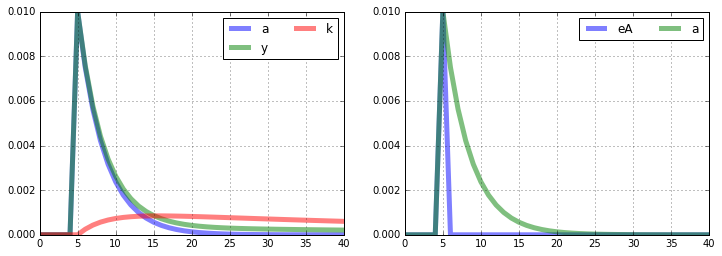

In [283]:
# Plot the computed impulse responses to a TFP shock
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(1,2,1)
model.irs['eA'][['a','y','k']].plot(lw='5',alpha=0.5,grid=True,ax = ax1).legend(loc='upper right',ncol=2)

ax2 = fig.add_subplot(1,2,2)
model.irs['eA'][['eA','a']].plot(lw='5',alpha=0.5,grid=True,ax = ax2).legend(loc='upper right',ncol=2)

In [285]:
# Compute stochastic simulation and print the simulated values.
# seed=126, T=201,covMat= [[parameters['sigma_squared'],0],[0,0]]
model.stoch_sim(seed=126,dropFirst=0,T=201,covMat= [[parameters['sigma_squared'],0],[0,0]])

# Print first 10 rows of model.simulated
print(model.simulated.head(10))

         eA   eK         a         k         y
0 -0.003974  0.0 -0.003974  0.000000 -0.003974
1 -0.003540  0.0 -0.006520 -0.000099 -0.006555
2  0.000482  0.0 -0.004408 -0.000261 -0.004499
3  0.003114  0.0 -0.000191 -0.000367 -0.000320
4  0.001185  0.0  0.001041 -0.000366  0.000913
5  0.008744  0.0  0.009525 -0.000334  0.009408
6  0.009071  0.0  0.016215 -0.000090  0.016183
7 -0.004548  0.0  0.007613  0.000317  0.007724
8  0.006752  0.0  0.012462  0.000502  0.012637
9 -0.006980  0.0  0.002366  0.000805  0.002648


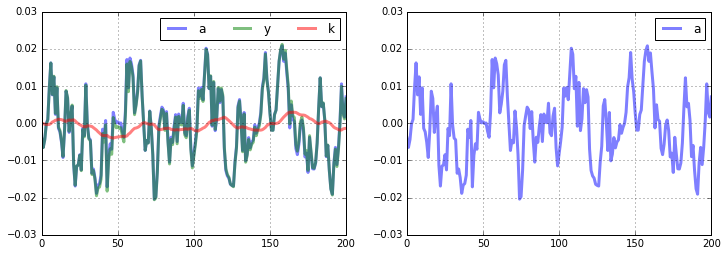

In [287]:
# Plot the computed stochastic simulation
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(1,2,1)
model.simulated[['a','y','k']].plot(lw='3',alpha=0.5,grid=True,ax = ax1).legend(loc='upper right',ncol=3)

ax2 = fig.add_subplot(1,2,2)
model.simulated[['a']].plot(lw='3',alpha=0.5,grid=True,ax = ax2).legend(loc='upper right',ncol=2)

In [289]:
# Compute correlations of simulated endogenous variables
model.simulated

,eA,eK,a,k,y
0,-0.003974,0.0,-0.003974,0.000000,-0.003974
1,-0.003540,0.0,-0.006520,-0.000099,-0.006555
2,0.000482,0.0,-0.004408,-0.000261,-0.004499
3,0.003114,0.0,-0.000191,-0.000367,-0.000320
4,0.001185,0.0,0.001041,-0.000366,0.000913
5,0.008744,0.0,0.009525,-0.000334,0.009408
6,0.009071,0.0,0.016215,-0.000090,0.016183
7,-0.004548,0.0,0.007613,0.000317,0.007724
8,0.006752,0.0,0.012462,0.000502,0.012637
9,-0.006980,0.0,0.002366,0.000805,0.002648


In [290]:
# Compute standard deviations of simulated endogenous variables